https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

In [1]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import torch

In [2]:
ROOT = Path("headsegmentationdataset/")

train_image_path = ROOT / "train"
train_mask_path = ROOT / "train_masks"

In [3]:
ALL_IMAGES = sorted(train_image_path.glob("*.png"))
ALL_MASKS = sorted(train_mask_path.glob("*.png"))

In [4]:
from typing import List
from catalyst import utils

from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(
        self,
        classes,
        images: List[Path],
        masks: List[Path] = None,
        transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms
        self.n_classes = len(classes)
        self.classes = classes

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = utils.imread(image_path)
        result = {"image": image}

        if self.masks is not None:
            mask = utils.imread(str(self.masks[idx]))
            mask = cv2.cvtColor(mask,cv2.COLOR_RGB2GRAY)
            one_hot = np.zeros((mask.shape[0], mask.shape[1], self.n_classes))
            for i, unique_value in enumerate(self.classes):
                one_hot[:, :, i][mask == unique_value] = 1
            result["mask"] = one_hot

        if self.transforms is not None:
            result = self.transforms(**result)

        result["filename"] = image_path.name

        return result

In [5]:
CLASSES = [0, 29, 76, 105, 128, 150, 179, 211, 226, 255]
dataset = SegmentationDataset(CLASSES, ALL_IMAGES, ALL_MASKS)

In [6]:
import albumentations as albu
from albumentations.pytorch import ToTensor

In [7]:
def pre_transforms(image_size=224):
    return [albu.Resize(image_size, image_size, p=1)]

def post_transforms():
    return [albu.Normalize(), ToTensor(num_classes=9)]


def hard_transforms():
    result = [
      albu.Cutout(),
      albu.RandomBrightnessContrast(
          brightness_limit=0.1, contrast_limit=0.1, p=0.3
      ),
      albu.GridDistortion(p=0.3),
    ]

    return result

def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [8]:
train_transforms = compose([
    pre_transforms(),
    hard_transforms(),
    post_transforms(),
])
valid_transforms = compose([pre_transforms(), post_transforms()])
visualize_transforms = compose([pre_transforms(), hard_transforms()])

In [9]:
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int,
    valid_size: float = 0.2,
    batch_size: int = 32,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
      classes = CLASSES,
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
      classes = CLASSES,
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Catalyst uses torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And expect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [10]:
batch_size = 24
random_state = 16

loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=random_state,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size
)

In [11]:
def set_requires_grad(model, value=False):
    for param in model.parameters():
        param.requires_grad = value

In [12]:
import segmentation_models_pytorch as smp
CLASSES = [0, 29, 76, 105, 128, 150, 179, 211, 226, 255]
aux_params= None
model = smp.FPN(encoder_name="mobilenet_v2", classes=len(CLASSES), aux_params=aux_params)
model_state = torch.load("./logs/segmentation/checkpoints_celeb_20epohs_mobilenetv2/best_full.pth")

In [13]:
# head = model.segmentation_head

In [14]:
model.load_state_dict(model_state['model_state_dict'])

<All keys matched successfully>

In [15]:
# set_requires_grad(model, False)
# model.decoder.p5.requires_grad_(False)
# model.encoder.features[0].requires_grad_(False)
# model.encoder.features[1].requires_grad_(False)
# model.encoder.features[2].requires_grad_(False)
# model.encoder.features[3].requires_grad_(False)

# model.encoder.features.requires_grad_(False)
# model.decoder.requires_grad_(False)

model.encoder.features.requires_grad_(True)
model.decoder.requires_grad_(True)

print(model)

FPN(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False

In [16]:
# model.segmentation_head = head

In [17]:
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss, FocalLossBinary

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(threshold=0.5),
    "bce": nn.BCEWithLogitsLoss(),
    "focal": FocalLossBinary(threshold=0.5)
    # TODO change to MultyClass
}
#https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/14

In [18]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

encoder_learning_rate = 0.001

# Since we use a pre-trained encoder, we will reduce the learning rate on it.
# weight_decay - parameter adds a L2 penalty to the cost which can effectively lead to to smaller model weights
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.0001)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
learning_rate = 0.001
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0001)
optimizer = Lookahead(base_optimizer)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

In [19]:
from catalyst.dl import SupervisedRunner

num_epochs = 30
logdir = "./logs/segmentation"

device = utils.get_device()
print(f"device: {device}")

runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

device: cuda


In [20]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_focal",
        criterion_key="focal"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8, "loss_focal":1.0},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
]

In [21]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # for FP16. It uses the variable from the very first cell
    fp16=None,
    # prints train logs
    verbose=True,
)

Early exiting                                                                                                                                                   
1/30 * Epoch (train):  21% 46/220 [00:17<01:01,  2.82it/s, dice=0.868, iou=0.767, loss=0.400, loss_bce=0.063, loss_dice=0.132, loss_focal=0.018, loss_iou=0.200]

/home/kuskov/anaconda3/envs/otus_cv/lib/python3.8/site-packages/catalyst/core/callbacks/optimizer.py:137: UserWarning:

This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)



In [25]:
from pathlib import Path
ROOT = Path("headsegmentationdataset/")
test_image_path = ROOT / "test3"
TEST_IMAGES = sorted(test_image_path.glob("*.jpg"))

In [26]:
# create test dataset
test_dataset = SegmentationDataset(
    CLASSES,
    TEST_IMAGES,
    transforms=valid_transforms
)

num_workers: int = 4

infer_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

# this get predictions for the whole loader
predictions = np.vstack(list(map(
    lambda x: x["logits"].cpu().numpy(),
    runner.predict_loader(loader=infer_loader, resume=f"{logdir}/checkpoints/best.pth")
    # runner.predict_loader(loader=infer_loader, resume=f"{logdir}/checkpoints/train.1.exception_KeyboardInterrupt.pth")
)))

print(type(predictions))
print(predictions.shape)

<class 'numpy.ndarray'>
(2, 10, 224, 224)


tensor([[[ 11.0451,  11.1039,  11.1627,  ...,   8.8951,   8.5164,   8.1377],
         [ 11.3206,  11.4167,  11.5128,  ...,   9.2674,   8.9436,   8.6199],
         [ 11.5961,  11.7295,  11.8629,  ...,   9.6396,   9.3709,   9.1021],
         ...,
         [  1.0658,   1.1146,   1.1633,  ...,   6.1584,   6.0268,   5.8953],
         [  1.2436,   1.3240,   1.4044,  ...,   5.8982,   5.7952,   5.6922],
         [  1.4214,   1.5334,   1.6454,  ...,   5.6381,   5.5636,   5.4891]],

        [[-31.4481, -31.1486, -30.8490,  ..., -17.3340, -16.6938, -16.0536],
         [-32.4971, -32.0641, -31.6312,  ..., -18.4858, -17.8742, -17.2627],
         [-33.5461, -32.9797, -32.4133,  ..., -19.6376, -19.0547, -18.4718],
         ...,
         [-13.1227, -12.9917, -12.8606,  ..., -16.1477, -15.6238, -15.0999],
         [-13.6528, -13.4521, -13.2514,  ..., -15.3019, -14.8183, -14.3347],
         [-14.1829, -13.9126, -13.6423,  ..., -14.4562, -14.0128, -13.5695]],

        [[-25.8745, -26.6929, -27.5113,  ...

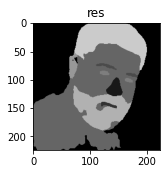

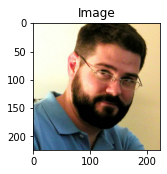

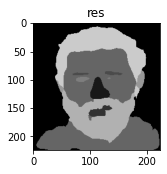

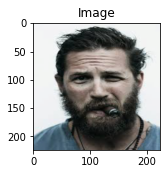

In [29]:
import torch
import numpy
# p = predictions[0].permute(1, 2, 0)
# print (p.shape)
import torch
max_count = 62
#
# masks = []
for i, (features, logits) in enumerate(zip(test_dataset, predictions)):
    # print(features["image"])
#     image = utils.tensor_to_ndimage(features["image"])
#
    # slices
    print(torch.from_numpy(logits))
    res = torch.argmax(torch.from_numpy(logits), dim=0)
    print(res.shape)
    res = numpy.asarray(res)
    v = 255/len(CLASSES)
    res = res*v - 1
    res = res.astype("int")

    plt.figure(figsize=(5, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(res, cmap='gray', vmin=0, vmax=255)
    plt.title(f"res")

    # image is ok
    image = utils.tensor_to_ndimage(features["image"])
    plt.figure(figsize=(5, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image")



    if i >= max_count:
        break
plt.show()